In [1]:
import findspark
findspark.init('/home/sak/spark-2.4.3-bin-hadoop2.7')
import pyspark
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("sajad").setMaster("local")
sc = SparkContext(conf=conf)

from pyspark.sql import SparkSession
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


from pyspark.sql.functions import explode
from pyspark.sql.functions import split

In [62]:
data_O = spark.read.load('creditcard.csv', 
                          format='csv', 
                          header='true', 
                          inferSchema='true')

type(data_O)

pyspark.sql.dataframe.DataFrame

In [3]:
classFreq = data_O.groupBy("Class").count()
classFreq.show()


+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



In [61]:
import pandas as pd
data= data_O.toPandas()
data= data.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = data.loc[data['Class'] == 1]
non_fraud_df = data.loc[data['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.shape

(984, 31)

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


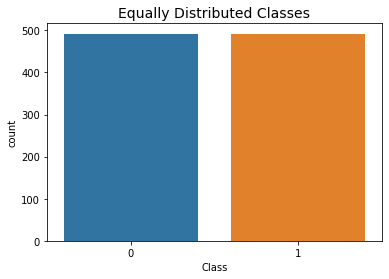

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot('Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

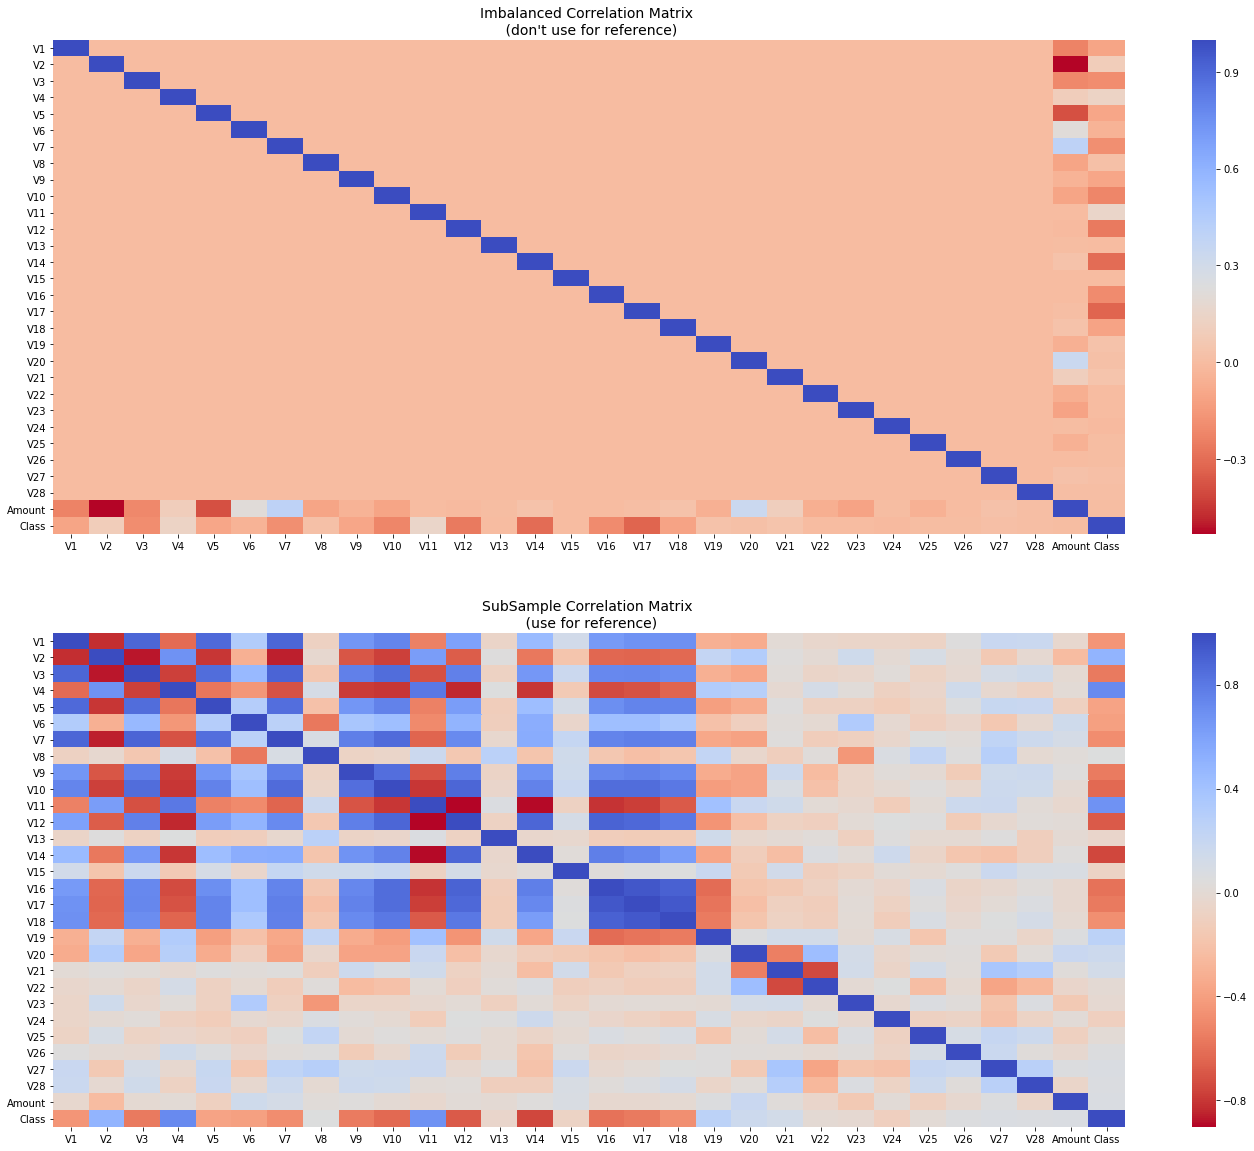

In [9]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

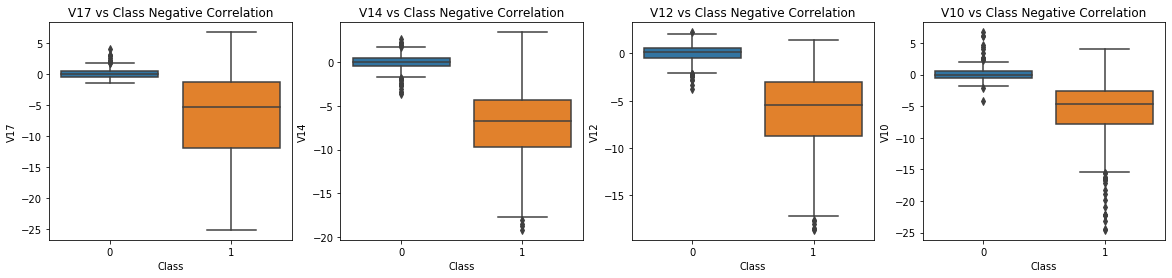

In [10]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df,  ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df,  ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

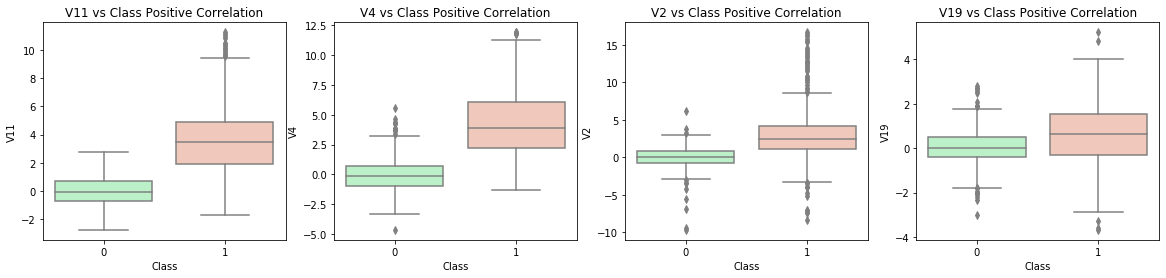

In [60]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

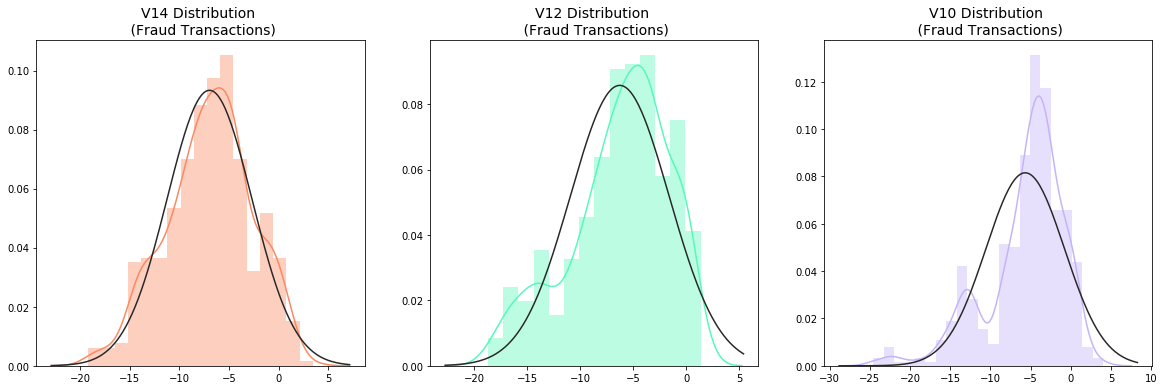

In [11]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [12]:
import numpy as np


# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)


# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25


v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))


type(new_df)

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.4937733551053, -18.8220867423816, -18.0499976898594, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.5536970096458, -18.6837146333443, -18.4311310279993, -18.0475965708216]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-22.1870885620007, -15.123752

pandas.core.frame.DataFrame

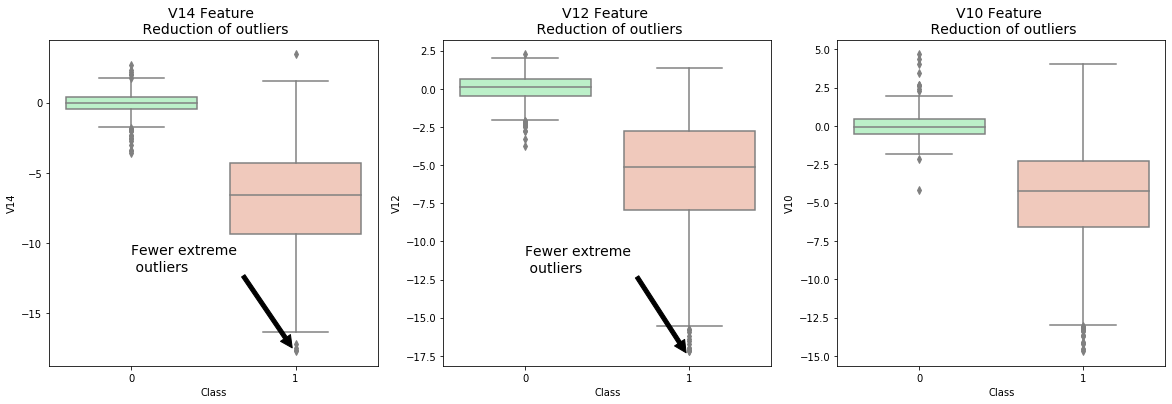

In [13]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()



In [14]:
dfff = spark.createDataFrame(new_df)

In [15]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
win = Window().orderBy('Time')
dfff = dfff.withColumn("idx", row_number().over(win))

In [16]:
dfff.head()

Row(Time=Decimal('406.000000000000000000'), V1=-2.3122265423263, V2=1.95199201064158, V3=-1.60985073229769, V4=3.9979055875468, V5=-0.522187864667764, V6=-1.42654531920595, V7=-2.53738730624579, V8=1.39165724829804, V9=-2.77008927719433, V10=-2.77227214465915, V11=3.20203320709635, V12=-2.89990738849473, V13=-0.595221881324605, V14=-4.28925378244217, V15=0.389724120274487, V16=-1.14074717980657, V17=-2.83005567450437, V18=-0.0168224681808257, V19=0.416955705037907, V20=0.126910559061474, V21=0.517232370861764, V22=-0.0350493686052974, V23=-0.465211076182388, V24=0.320198198514526, V25=0.0445191674731724, V26=0.177839798284401, V27=0.261145002567677, V28=-0.143275874698919, Amount=0.0, Class=1, idx=1)

In [17]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [18]:
training_df = dfff.rdd.map(lambda x: (DenseVector(x[0:29]),x[30],x[31]))


training_df = spark.createDataFrame(training_df,["features","label","index"])

training_df.head()

Row(features=DenseVector([406.0, -2.3122, 1.952, -1.6099, 3.9979, -0.5222, -1.4265, -2.5374, 1.3917, -2.7701, -2.7723, 3.202, -2.8999, -0.5952, -4.2893, 0.3897, -1.1407, -2.8301, -0.0168, 0.417, 0.1269, 0.5172, -0.035, -0.4652, 0.3202, 0.0445, 0.1778, 0.2611, -0.1433]), label=1, index=1)

In [19]:
training_df = training_df.select("index","features","label")

train_data, test_data = training_df.randomSplit([.8,.2],seed=1234)


In [20]:
train_data.groupBy("label").count().show()



+-----+-----+
|label|count|
+-----+-----+
|    0|  411|
|    1|  369|
+-----+-----+



In [21]:
test_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   78|
|    1|   88|
+-----+-----+



In [22]:

gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=8)

In [23]:
model = gbt.fit(train_data)

In [24]:
predictions = model.transform(test_data)


In [25]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|   77|
|       1.0|   89|
+----------+-----+



In [26]:

evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.986451048951049

In [27]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))

In [28]:
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   86|
|              0|   80|
+---------------+-----+



In [29]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   78|
|    1|   88|
+-----+-----+



In [30]:
from pyspark.sql.functions import col

In [31]:
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100
FraudPredictionAccuracy

97.72727272727273

In [32]:
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()

In [33]:
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()

In [34]:

fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()


In [35]:
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)

print("Recall: ",tp/(tp+fn))
print("Precision: ", tp/(tp+fp))

True Positive:  86 
True Negative:  75 
False Positive:  3 
False Negative:  2
Recall:  0.9772727272727273
Precision:  0.9662921348314607
